In [1]:
import numpy as np
import pycuda.autoinit
from pycuda import gpuarray
from pycuda.elementwise import ElementwiseKernel
import matplotlib.pyplot as plt

In [2]:
mandel_ker = ElementwiseKernel(
    "pycuda::complex<float> *lattice, float *mandelbrot_graph, int max_iters, float upper_bound",
    """
    mandelbrot_graph[i] = 1;
    pycuda::complex<float> c = lattice[i];
    pycuda::complex<float> z(0, 0);
    for (int j = 0; j < max_iters; j++) {
        z = z * z + c;
        if (abs(z) > upper_bound) {
            mandelbrot_graph[i] = 0;
            break;
        }
    }
    """,
    "mandel_ker"
)

In [3]:
def gpu_mandelbrot(width, height, real_low, real_high, imag_low, imag_high,
                   max_iters, upper_bound):
    real_vals = np.matrix(np.linspace(real_low, real_high, width), np.complex64)
    imag_vals = np.matrix(np.linspace(imag_low, imag_high, height), np.complex64) * 1j
    mandelbrot_lattice = np.array(real_vals + imag_vals.transpose(), np.complex64)
    
    mandelbrot_lattice_gpu = gpuarray.to_gpu(mandelbrot_lattice)
    mandelbrot_graph_gpu = gpuarray.empty(shape=mandelbrot_lattice_gpu.shape, dtype=np.float32)
    mandel_ker(mandelbrot_lattice_gpu, mandelbrot_graph_gpu, np.int32(max_iters), np.float32(upper_bound))
    mandelbrot_graph = mandelbrot_graph_gpu.get()
    
    return mandelbrot_graph


In [6]:
%%timeit -n 10

width, height = 512, 512
real_low, real_high = -2, 2
imag_low, imag_high = -2, 2
max_iters = 256
upper_bound = 2.0

mandel = gpu_mandelbrot(width, height, real_low, real_high,
                        imag_low, imag_high, max_iters, upper_bound)

12 ms ± 2.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


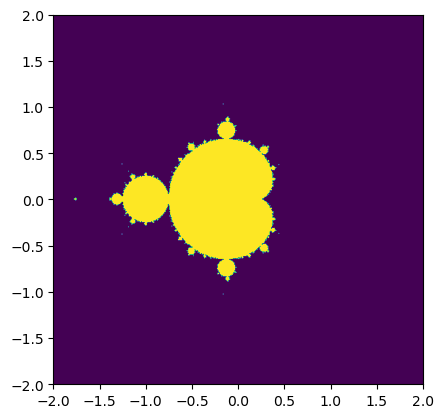

In [5]:
fig = plt.figure(1)
plt.imshow(mandel, extent=(real_low, real_high, imag_low, imag_high))
plt.show()